In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf

import models
import confusion
import config

%load_ext line_profiler

Using TensorFlow backend.


In [2]:
tf_version = tf.__version__
tf_version

'1.13.1'

In [3]:
# speak softly
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

### Model Selection

#### TPU Accelerator on Raspberry Pi

#### GPU or Standard TensorFlow

In [4]:
m = models.ClassifyRegular()
m.setup_telemetry('192.168.86.47')

### Profile Data Name  
Label for statistics compilation  

In [5]:
profile_name = "win10_i7_tf_{}GPU_Tel".format(tf_version)
profile_name

'win10_i7_tf_1.13.1GPU_Tel'

### Load MobileNetV2

In [6]:
m.load_model()

Instructions for updating:
Colocations handled automatically by placer.


### Test on single known image of a German Shepherd

### Run Classification on all Stanford Dog Images

In [7]:
p = %prun -r m.predict_dataset(config.download_directory + \
                               os.path.sep + 'Images', verbose=False)

>> Telemetry Enabled
>> Telemetry Done
 

### Save Profile Results

In [8]:
p.dump_stats(config.data_directory + os.path.sep + 
             profile_name + "_pstats.txt")

### Collate Predictions and Evaluate Model Performance

In [9]:
m.collate_predictions()

In [10]:
df = m.df

In [11]:
df.head()

,y_true,y_pred
0,chihuahua,chihuahua
1,chihuahua,chihuahua
2,chihuahua,chihuahua
3,chihuahua,chihuahua
4,chihuahua,chihuahua


In [12]:
dog_names = df.y_true.unique()
predicted_labels = df.y_pred.unique()

#### Clean Results  
Assign the predicted label to 'other' if it is not a dog name

In [13]:
df.y_pred = df.y_pred.apply(lambda x: x if x in dog_names else 'other')

Insert another label to hold the 'other' labels

In [14]:
df = df.append(pd.DataFrame({'y_true':'other','y_pred':'other'}, index=[0]),
                ignore_index=True)

##### Overall classification accuracy

In [15]:
acc = df.y_pred == df.y_true
acc.sum()/len(acc)

0.8041397405373889

##### Classification accuracy of labeling it some breed of dog

In [16]:
df['y_pred_dog'] = df.y_pred.apply(lambda x: True if x in dog_names else False)
df.y_pred_dog.sum()/len(df)

0.9334823380788105

In [17]:
df.head()

,y_true,y_pred,y_pred_dog
0,chihuahua,chihuahua,True
1,chihuahua,chihuahua,True
2,chihuahua,chihuahua,True
3,chihuahua,chihuahua,True
4,chihuahua,chihuahua,True


Save predictions for comparison

In [18]:
df.to_csv(config.data_directory + os.path.sep + 
          profile_name+'_predictions.csv', sep=',', index=False)

### Confusion Matrix Plot

In [19]:
cm = confusion.Matrix(y=df.y_true, p=df.y_pred)

In [20]:
cm.a

array([[119.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 226.,   0., ...,   0.,   0.,   0.],
       [  0.,   0., 160., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 143.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0., 125.]])

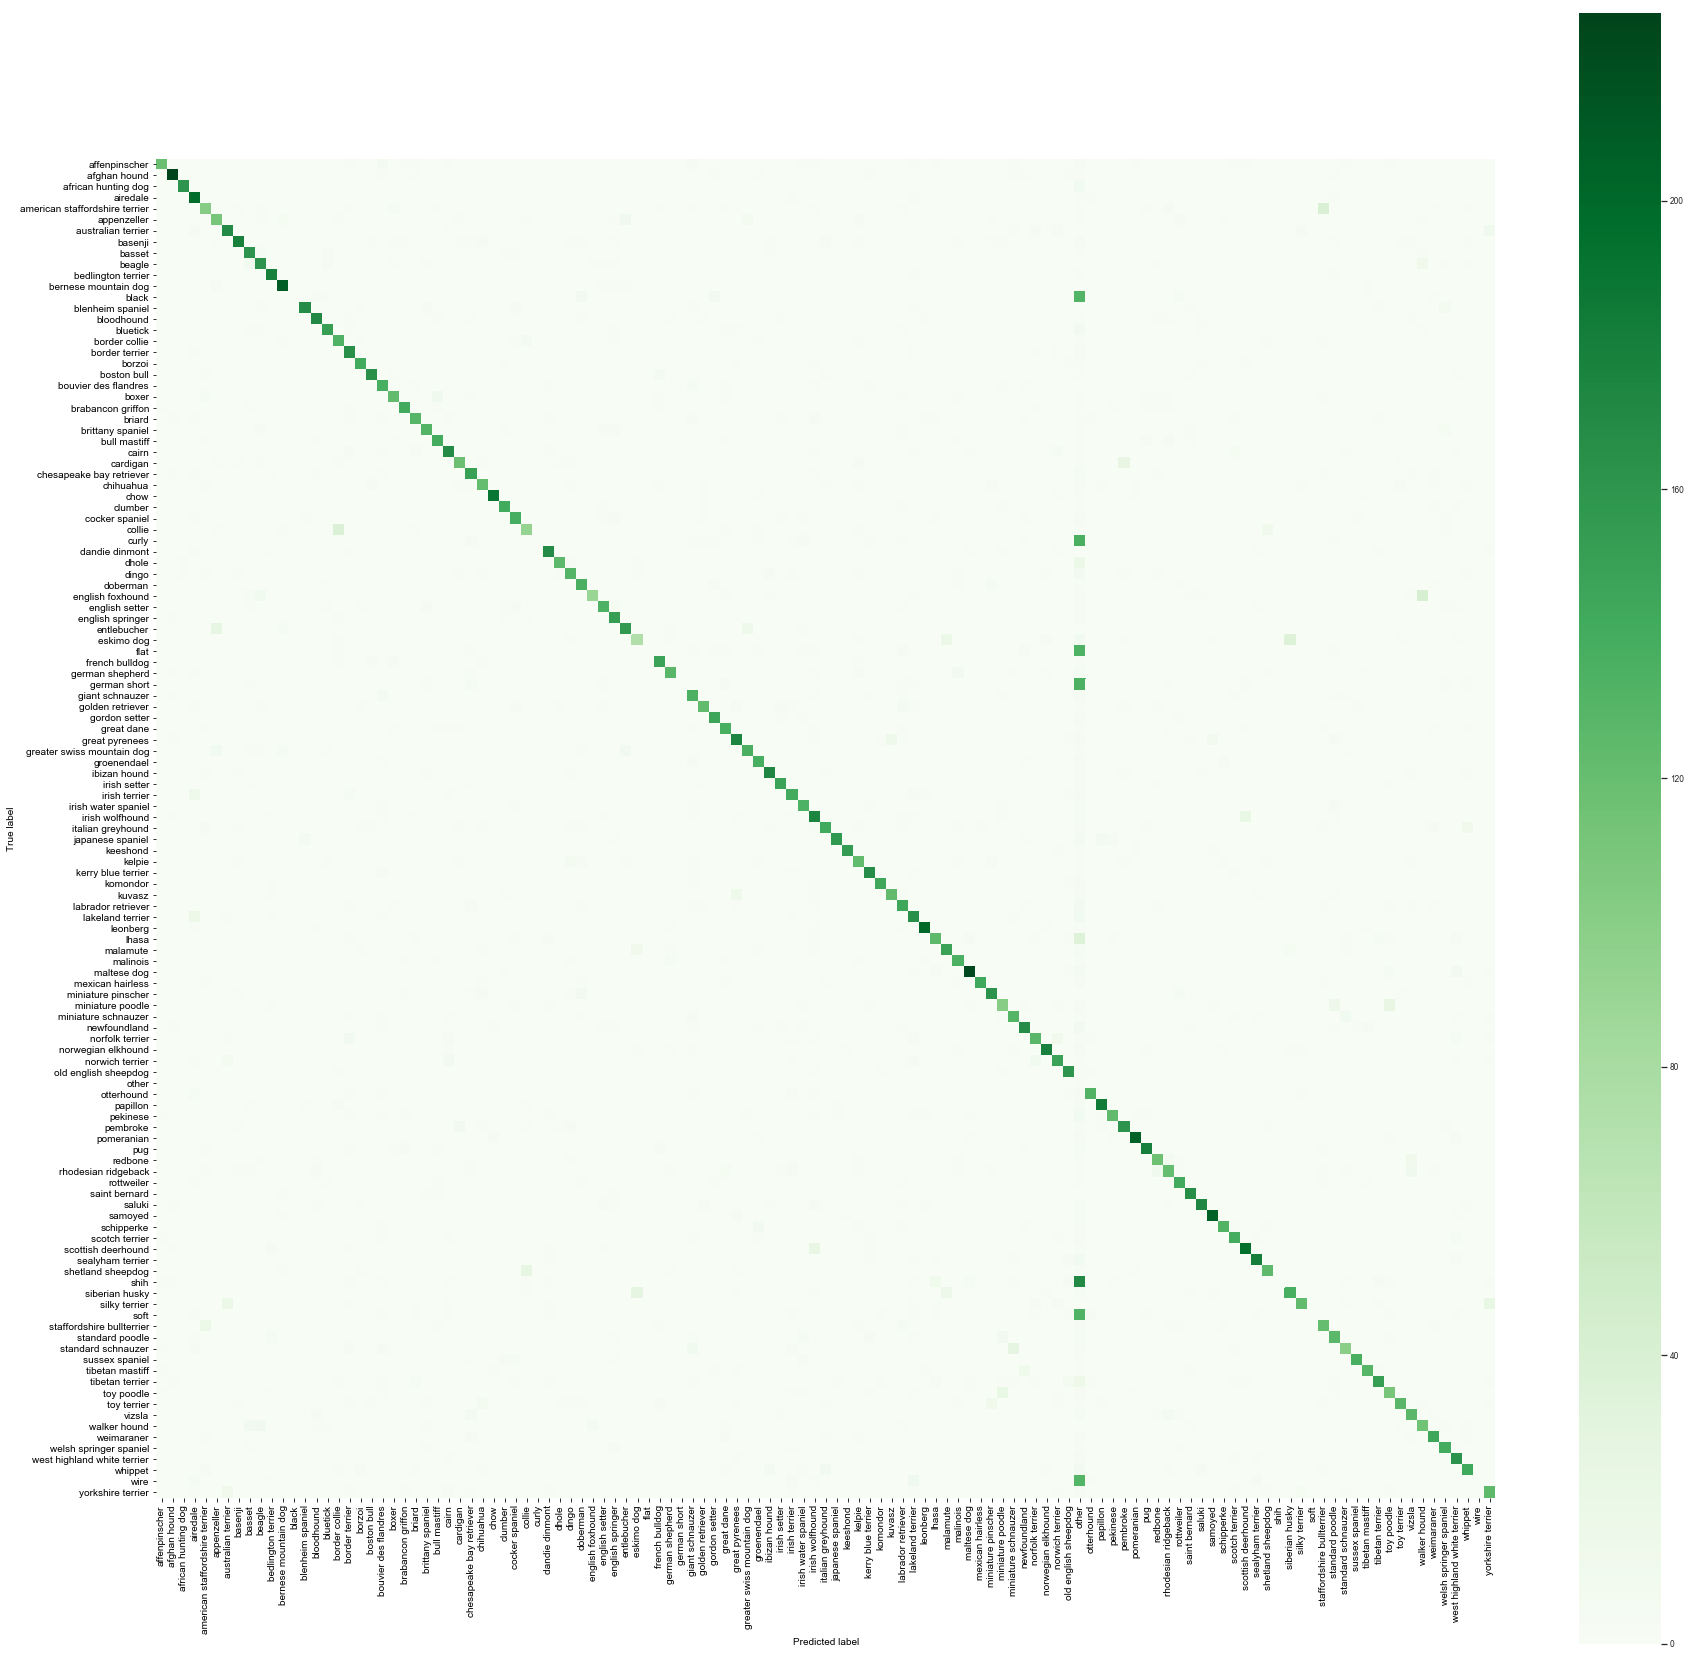

In [21]:
fig = cm.plot(cmap='Greens', font_scale=0.75, 
        annot_kws={"size": 14}, ticklabels=True, 
        annot=False, figsize=30)